# Efficient Frontier Optimisation  
## Wei Jie Huang 31500315


### Imports

In [2]:
import data, calculations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.expected_returns import returns_from_prices, log_returns_from_prices, mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

%load_ext autoreload
%autoreload 2

In [3]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

# Introduction
For many, creating a stock portfolio is not the hardest part of investment, but rather, the allocation of assets into each respective stock. For the calculation of these weights, we utilise mean-variance optimsation, formulated by Harry Markowitz [1]. Particularly, the utilise the PyPortfolioOpt library, which undertakes the mathematical optimisation to output the correct weights and calculations of performance metrics. 

Particularly, through a single line of code:
    
    efficient_frontier.min_volatility

we can garner weights which minimises the overall volatility of the whole portfolio, in addition to the output of the annual expected return, volatilty and sharpe ratios. 

Thus, the following notebook examines two methods in finding the weights which attest to a good portfolio: 

1. Unconstrained Efficient Frontier Optisation.
2. Constrained Efficient Frontier Optimisation.

The unconstrained model produces weights which minimises the volatility, while the constrained model contains added restrictions, including a maximum volatilty bound, sector restraints and L2 regularisation.

## Performance Metrics

There are three performance metrics we examine in detail:

1. Expected Return - Profit margin of the portfolio
2. Volatility - Overall risk
3. Sharpe Ratio - Ratio between return and risk.  

More particularly, the Sharpe ratio examines how much return for the amount of risk they have invested. A Sharpe ratio of 1.0 details that the investor expects an even amount of return for the risk they have committed, while a ratio of 2.0 suggests that the portfolio will output double the amount of return for the risk they have ventured. 

# Modelling

## Gathering & Cleaning the Data

The following notebook describes the process of finding these weightings for a random portfolio consisting of stocks 2015 through 2019 which have reached the S&P 500.

Each portfolio contains 100 stocks. Though this may seem excessive, this decision was made to better reflect the impact of sector restrictions, as well as the application of L2 regularisation, within a portfolio's weightings later in the notebook.

In [4]:
random_portfolios = data.generate_random_portfolios(data.import_range(date_from="2015"), no_stocks=100, no_portfolios=50)
hide_toggle()

# Unconstrained Efficient Frontier Optimisation

In [5]:
# The code below describes the optimisation process of the model

# Create lists to append results of the pypfopt libraries' functions, as well as a DataFrame for the results output. 
# We particularly are interested in the expected return and weights of each stock. 

portfolios_expected_returns, portfolios_covariance_matrices, portfolios_efficient_frontiers, portfolios_weights = [], [], [], []
results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

# Loop through all portfolios to calculate their respective expected returns, covariance matricies, weights and performance. 
for index, sample_portfolio in enumerate(random_portfolios):
    sample_expected_return = mean_historical_return(sample_portfolio)
    sample_covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    sample_efficient_frontier = EfficientFrontier(sample_expected_return, sample_covariance_matrix)
    
# Optimise the weights within the EfficientFrontier object for minimum volatility throughout the whole portfolio
    _ = sample_efficient_frontier.min_volatility()
    sample_weights = sample_efficient_frontier.clean_weights()
    
    portfolios_expected_returns.append(sample_expected_return)
    portfolios_covariance_matrices.append(sample_covariance_matrix)
    portfolios_efficient_frontiers.append(sample_efficient_frontier)
    portfolios_weights.append(pd.DataFrame(sample_weights.values(), columns=["Weights"], index=sample_weights.keys()))
    
    results.loc[index] = sample_efficient_frontier.portfolio_performance(verbose=False)
hide_toggle()

The DataFrames below describe the best portfolios which can be produced via the simulation. In particular, note that the expected return reaches a maximum of 9.4%, volatility a minimum of 7%, and the Sharpe ratio hits a ceiling at 0.90.

In [6]:
data.display_side_by_side(
    [results.sort_values("Expected Return", ascending=False)[:3],
    results.sort_values("Volatility")[:3],
    results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Top three portfolios sorted by expected returns", "Top three portfolios sorted by volatility", "Top three portfolios sorted by Sharpe ratio"])

,Expected Return,Volatility,Sharpe Ratio
38,0.093707,0.085696,0.860091
39,0.088672,0.083105,0.826321
41,0.087233,0.074492,0.902551
,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874092
20,0.070270,0.071344,0.704614
1,0.070372,0.072827,0.691664
,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902551
2,0.080989,0.069774,0.874092


The issue which pertains, are that the portfolios remain risky, as the Sharpe ratio never reaches above 0.9. This results in portfolios which are always suboptimial, in the sense that investors do not receive the **same** level of return for the risk they have inputted.

In [7]:
index_best_return = results["Expected Return"].argmax()
portfolios_weights[index_best_return].sort_values("Weights", ascending=False).head().style.set_caption("Top 5 weights for portfolio with highest expected return")

,Weights
EVRG US Equity,0.133680
WM US Equity,0.123180
MCD US Equity,0.118960
CCI US Equity,0.067450
K US Equity,0.053740


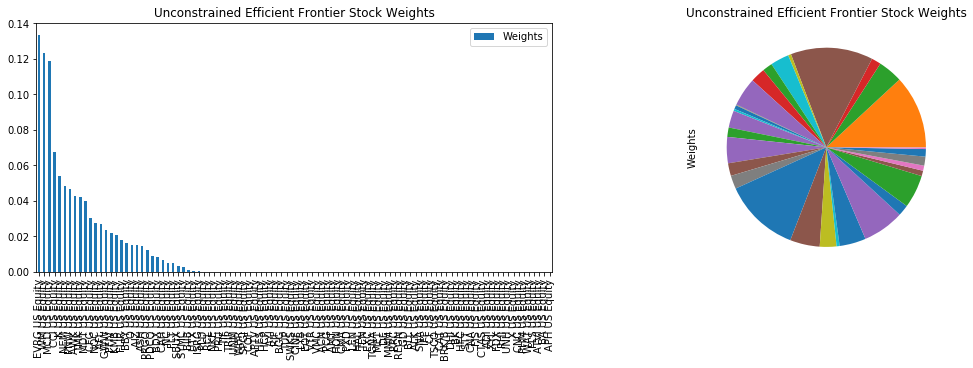

In [8]:
    fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), constrained_layout=True)

    portfolios_weights[index_best_return].sort_values("Weights", ascending=False).plot.bar(ax=axes[0], title = "Unconstrained Efficient Frontier Stock Weights");
    portfolios_weights[index_best_return]["Weights"].plot.pie(ax=axes[1], labels = None, title = "Unconstrained Efficient Frontier Stock Weights");

In [9]:
p = list(portfolios_weights[index_best_return]["Weights"]);

num_small = len([i for i in range(len(p)) if p[i] <= 1e-4])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

68/100 tickers have zero weight


Under further analysis, the above graphics display the relative abundance of zero weighted stocks. Thus, we move onto optimisation with constraints, whereby we apply diversification techniques to hopefully improve performance of portfolios

# Purpose of Constraints 

The unconstrained model above depicts the key issue regarding the original optimisation model: the lack of diversification. 

Optimisation attempts to find the best asset distribution for the given risk. Markowitz's modern portfolio theory describes the main benefits portfolios which are well diverse, where the crux is to present portfolios which are highly diverse to smooth the equity curve, leading to a high return per risk rather than trading an individual asset. 

Thus, we apply diversification constraints to the previous efficient frontier model and contrast the results. 


### Minimal Volatilty

There exists a maximal bound on all following constraint models to reflect real world investments in a greater light. For any investors' portfolio, whether it be a day trader or an employee's superannuation fund, they will typically prefer (or even restrict) their assets and portfolio such that the losses are kept to a minimum. Thus, the model is constrained such that portfolios must contain volatility below 15%. 


### Sector Constraints

Via the covariance matrix within a portfolio, we can observe the relationship one stock has with another. If this correlation is high for many 
stocks within the portfolio, then it's common for that portfolio to contain many stocks which are catagorised into same sector. 

Thus, to increase diversification within the portfolio, we optimise weights such that a portfolio does not rely too heavily on a specific sector, such as placing an upper limit on technology stocks or a minimum weighting on utilites. Through this, we ensure a more diversified portfolio where we can hopefully present greater returns.

The first step is to look at generalised portfolios over a given time frame. We don't select a particular portfolio for the reason of observing which porfolios operate the best through the sector constraints; if we chose a portfolio containing the top 10 stocks with highest expected returns, the porfolio might not be diversified enough to distinguish the effect with these sector constraints. Thus, by analysing portfolios with randomised stocks, we can more easily quantify which stocks garnered the best returns when constraints are added into the optmisation criteria.

### L2 Regularisation (Ridge Regression)

When using the efficient frontier optimiser, there are many instances for portfolios to contain stocks with a weight of zero, hence as if the stock was not in the portfolio to begin with. To combat this issue of negligible weights, we utilise a regression technique called similar to L2 regularisation, otherwise known as ridge regularisation, adding a penalty term when calculating the risk via the covariance matrix. 

The added L2 penalty, which equals the square of the magnitude of coefficients for the weights of stocks get minimised by the optimiser. 

\begin{split}\begin{equation*} \underset{w}{\text{minimise}} ~ \left\{w^T \Sigma w + \gamma w^T w \right\} \end{equation*}\end{split}

If the weights are all equally distributed throughout the portfolio, then this value will be at a minimum, and will obtain a maximum value in the case of the entire portfolio being allocated to one asset. 

Thus, by adding this cost as a constraint, we push the optimisation model to choose different, non-zero weights for stocks which once were neglibile.

Though L2 regularisation is utilised in machine learning to keep weights small, in this specific context, the added term provides presents greater diversity.

## Sector Constraints

We begin by importing a dataframe which contains all the sectors for the given time period. 

This data has been scraped using wikipedia and a public API, Financial Modelling Prep, and cleaned within another notebook.

In [10]:
smp500_sectors = pd.read_csv('../sectors.csv', index_col=0)
smp500_sectors
print("11 unique GICS Sector classications for stocks.")
list(smp500_sectors["GICS Sector"].unique())

,GICS Sector
Symbol,
A US Equity,Healthcare
AA US Equity,Materials
AAL US Equity,Industrials
AAP US Equity,Consumer Discretionary
AAPL US Equity,Information Technology
...,...
XYL US Equity,Industrials
YUM US Equity,Consumer Discretionary
ZBH US Equity,Healthcare


11 unique GICS Sector classications for stocks.


['Healthcare',
 'Materials',
 'Industrials',
 'Consumer Discretionary',
 'Information Technology',
 'Consumer Staples',
 'Utilities',
 'Financials',
 'Real Estate',
 'Energy',
 'Communication Services']

## Modelling
Along with minimal risk constraints, we will now log the results for:

- Normal efficient frontiers
- Efficient frontiers with sector constraints
- L2 regularisation and sector constraint.

We decided to pick stocks from 2015 onwards, with each portfolio comprised of 50 stocks. If the number of stocks within a portfolio is too small, then the optimiser will output an error as it cannot reliabily partition weights into the given constraints.

## Uncorrelated Sectoring
In refernce to the correlation matrix of sectors published by Bloomberg[2], we can see that there are particular sectors which have low correlation values. If we optmise the constraints to include a minimum of both these values, we can hope to see an incease in return due to a growth in diversity.

In particular, a minimum of 15% in both Information Technology and Utilities have been chosen as a constraint, as they contain the lowest correlation value within the Bloomberg matrix. 

In [58]:
# Sectors without information have no lower bounds
sector_mapper = smp500_sectors["GICS Sector"].to_dict()

sector_lower = {
    "Information Technology": 0.15,
    "Utilities": 0.15,
}

sector_upper = {
    "Financials": 0.25,
    "Industrials": 0.25,
}
hide_toggle()

In [12]:
efficient_frontiers, efficient_frontiers_weights = [], []
efficient_frontiers_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

efficient_frontiers_sectors, efficient_frontiers_sectors_weights = [], []
efficient_frontiers_sectors_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

efficient_frontiers_sectors_L2, efficient_frontiers_sectors_L2_weights = [], []
efficient_frontiers_sectors_L2_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    # Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    efficient_frontiers.append(efficient_frontier)
    efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

    # Sector Contraints
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    efficient_frontiers_sectors.append(efficient_frontier)
    efficient_frontiers_sectors_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_sectors_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Sector Contraints with L2 Regularisation
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
    efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.05)  # Gamma is the tuning parameter
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    efficient_frontiers_sectors_L2.append(efficient_frontier)
    efficient_frontiers_sectors_L2_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_sectors_L2_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
hide_toggle()

In [13]:
index_best_efficient_frontier_sharpe = efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
index_best_sector_sharpe = efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
index_best_sector_L2_sharpe = efficient_frontiers_sectors_L2_results["Sharpe Ratio"].argmax()

In [57]:
data.display_side_by_side(
[efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ['Minimal Risk', 'Uncorrelated Sectors', 'Uncorrelated Sectors and L2'])

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.093793,0.075409,0.978569
2,0.085096,0.071202,0.914245
34,0.085784,0.077133,0.852863
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
41,0.081946,0.076758,0.807022


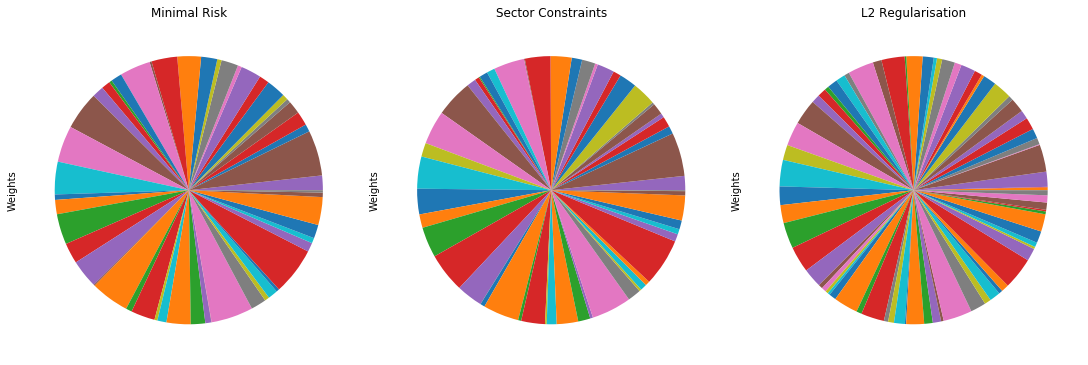

In [15]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True)

efficient_frontiers_weights[index_best_efficient_frontier_sharpe]["Weights"].plot.pie(ax=axes[0], labels=None, title="Minimal Risk");
efficient_frontiers_sectors_weights[index_best_efficient_frontier_sharpe]["Weights"].plot.pie(ax=axes[1], labels = None, title="Sector Constraints");
efficient_frontiers_sectors_L2_weights[index_best_efficient_frontier_sharpe]["Weights"].plot.pie(ax=axes[2], labels = None, title="L2 Regularisation");

**Comparision of weights by sector: portfolio 41**

In [17]:
no_constraints_weighted_dict = dict()
sector_constraints_weighted_dict = dict()
sector_L2_constraints_weighted_dict = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_weights[index_best_efficient_frontier_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    no_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_weights[index_best_sector_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sector_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_L2_weights[index_best_sector_L2_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sector_L2_constraints_weighted_dict[sector] = total_weight
    
df = pd.DataFrame([no_constraints_weighted_dict, sector_constraints_weighted_dict , sector_L2_constraints_weighted_dict],
                       index = ["Minimal Risk", "Sector Constraints", "Sector & L2 Constraints"] )
df

,Financials,Energy,Utilities,Healthcare,Materials,Consumer Staples,Consumer Discretionary,Communication Services,Real Estate,Industrials,Information Technology
Minimal Risk,0.09263,0.01003,0.20807,0.10215,0.09515,0.14556,0.13316,0.03730,0.04927,0.08832,0.03835
Sector Constraints,0.07911,0.00767,0.20680,0.08588,0.08190,0.13714,0.10978,0.02742,0.04309,0.07121,0.15000
Sector & L2 Constraints,0.18097,0.02792,0.19946,0.10232,0.02933,0.09957,0.10031,0.00147,0.05515,0.05349,0.15000


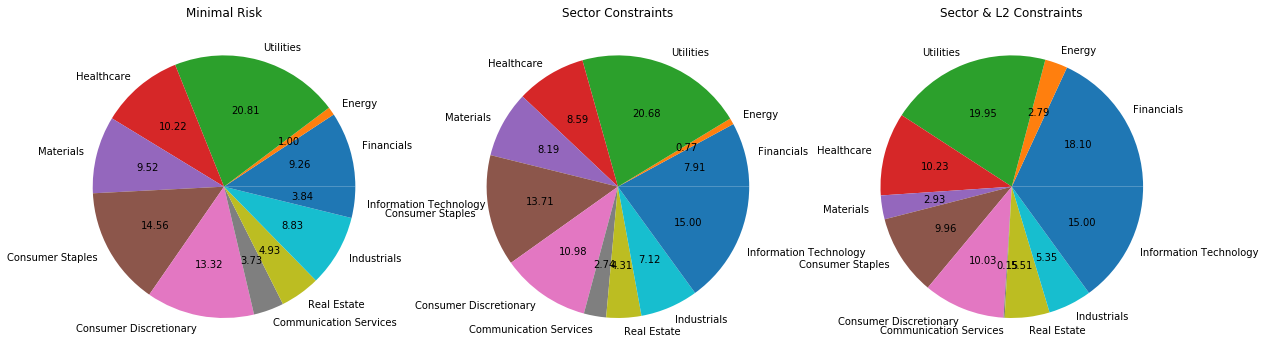

In [18]:
fig, axes = plt.subplots(1,3, figsize=(20,15))
for ax, idx in zip(axes, df.index):
    ax.pie(df.loc[idx], labels=df.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();

# Defensive stock constraint

If an economy is in a bear market whereby prices of stocks go down by 20% within a given time frame, then investors commonly place their assets into defensive sectors, such as consumer staples, healthcare and utilities.

Thus, lets see what happens when we change the sector mappings to that which place more emphasis on primarliy defensive stocks.

In [22]:
# Sectors without information have no lower bounds
sector_lower_defensive = {
    "Consumer Staples": 0.15,
    "Healthcare": 0.05,
    "Utilities": 0.15,   
}

sector_upper_defensive = {
    "Information Technology": 0.02, 
    "Real Estate": 0.02,
    "Communication Services": 0.02,
    "Consumer Discretionary": 0.15
}
hide_toggle()

In [23]:
def_efficient_frontiers, def_efficient_frontiers_weights = [], []
def_efficient_frontiers_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

def_efficient_frontiers_sectors, def_efficient_frontiers_sectors_weights = [], []
def_efficient_frontiers_sectors_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

def_efficient_frontiers_sectors_L2, def_efficient_frontiers_sectors_L2_weights = [], []
def_efficient_frontiers_sectors_L2_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    # Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    def_efficient_frontiers.append(efficient_frontier)
    def_efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    def_efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

    # Sector Contraints
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_defensive, sector_upper_defensive)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    def_efficient_frontiers_sectors.append(efficient_frontier)
    def_efficient_frontiers_sectors_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    def_efficient_frontiers_sectors_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Sector Contraints with L2 Regularisation
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_defensive, sector_upper_defensive)
    efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.1)  # Gamma is the tuning parameter
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    def_efficient_frontiers_sectors_L2.append(efficient_frontier)
    def_efficient_frontiers_sectors_L2_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    def_efficient_frontiers_sectors_L2_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

In [24]:
def_index_best_efficient_frontier_sharpe = def_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
def_index_best_sector_sharpe = def_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
def_index_best_sector_L2_sharpe = def_efficient_frontiers_sectors_L2_results["Sharpe Ratio"].argmax()

In [26]:
data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ['Minimal Risk', 'Defensive Sectors', 'Defensive Sectors and L2'])

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.085628,0.074657,0.879059
2,0.081281,0.069868,0.877098
39,0.088264,0.083560,0.816944
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
9,0.076125,0.076227,0.736292


In [28]:
def_no_constraints_weighted_dict = dict()
def_sector_constraints_weighted_dict = dict()
def_sector_L2_constraints_weighted_dict = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in def_efficient_frontiers_weights[def_index_best_efficient_frontier_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    def_no_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in def_efficient_frontiers_sectors_weights[def_index_best_sector_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    def_sector_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_L2_weights[def_index_best_sector_L2_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    def_sector_L2_constraints_weighted_dict[sector] = total_weight
    
df2 = pd.DataFrame([def_no_constraints_weighted_dict, def_sector_constraints_weighted_dict , def_sector_L2_constraints_weighted_dict],
                       index = ["Minimal Risk", "Sector Constraints", "Sector & L2 Constraints"] )
df2

,Financials,Energy,Utilities,Healthcare,Materials,Consumer Staples,Consumer Discretionary,Communication Services,Real Estate,Industrials,Information Technology
Minimal Risk,0.09263,0.01003,0.20807,0.10215,0.09515,0.14556,0.13316,0.03730,0.04927,0.08832,0.03835
Sector Constraints,0.09727,0.01194,0.22117,0.11166,0.10240,0.15273,0.14712,0.02000,0.02000,0.09573,0.01991
Sector & L2 Constraints,0.18097,0.02792,0.19946,0.10232,0.02933,0.09957,0.10031,0.00147,0.05515,0.05349,0.15000


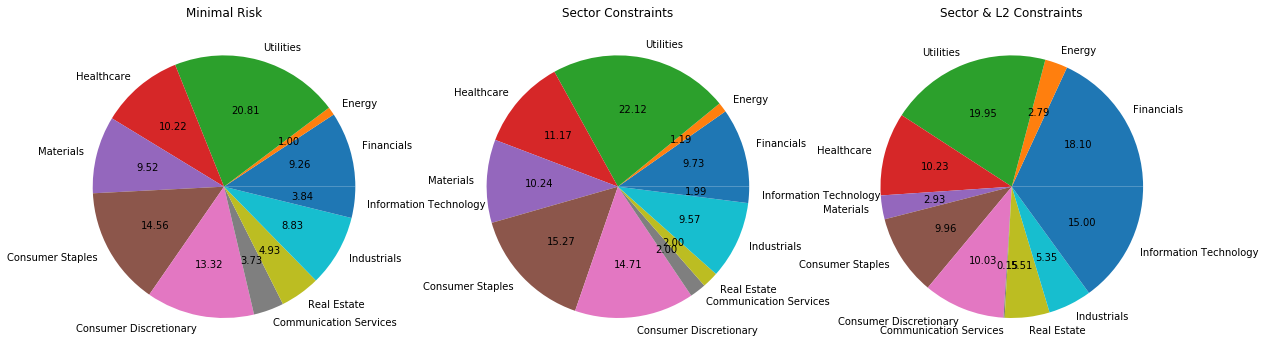

In [29]:
fig, axes = plt.subplots(1,3, figsize=(20,15))
for ax, idx in zip(axes, df2.index):
    ax.pie(df2.loc[idx], labels=df2.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();

## High Consumer Confidence

Now, lets place minimums on stocks which do well in a bull market. 

In [33]:
sector_lower_bull = {
    "Materials": 0.15,
    "Financials": 0.15,
    "Consumer Discretionary": 0.15    
}

sector_upper_bull = {
}

In [34]:
bull_efficient_frontiers, bull_efficient_frontiers_weights = [], []
bull_efficient_frontiers_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

bull_efficient_frontiers_sectors, bull_efficient_frontiers_sectors_weights = [], []
bull_efficient_frontiers_sectors_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

bull_efficient_frontiers_sectors_L2, bull_efficient_frontiers_sectors_L2_weights = [], []
bull_efficient_frontiers_sectors_L2_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    # Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    bull_efficient_frontiers.append(efficient_frontier)
    bull_efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    bull_efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

    # Sector Contraints
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_bull, sector_upper_bull)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    bull_efficient_frontiers_sectors.append(efficient_frontier)
    bull_efficient_frontiers_sectors_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    bull_efficient_frontiers_sectors_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Sector Contraints with L2 Regularisation
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_bull, sector_upper_bull)
    efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.1)  # Gamma is the tuning parameter
#     _ = efficient_frontier.efficient_risk(0.15)    

    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    bull_efficient_frontiers_sectors_L2.append(efficient_frontier)
    bull_efficient_frontiers_sectors_L2_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    bull_efficient_frontiers_sectors_L2_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

In [35]:
bull_index_best_efficient_frontier_sharpe = bull_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
bull_index_best_sector_sharpe = bull_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
bull_index_best_sector_L2_sharpe = bull_efficient_frontiers_sectors_L2_results["Sharpe Ratio"].argmax()

In [36]:
data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["No Constraints", "Bullish Sectors", "Bullish Sectors and L2"])

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
38,0.096299,0.086483,0.882234
41,0.085804,0.075100,0.876222
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
41,0.073811,0.077979,0.690060


**Comparision of weights by sector**

In [38]:
bull_no_constraints_weighted_dict = dict()
bull_sector_constraints_weighted_dict = dict()
bull_sector_L2_constraints_weighted_dict = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in bull_efficient_frontiers_weights[bull_index_best_efficient_frontier_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    bull_no_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in bull_efficient_frontiers_sectors_weights[bull_index_best_sector_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    bull_sector_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_L2_weights[bull_index_best_sector_L2_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    bull_sector_L2_constraints_weighted_dict[sector] = total_weight
    
df3 = pd.DataFrame([bull_no_constraints_weighted_dict, bull_sector_constraints_weighted_dict , bull_sector_L2_constraints_weighted_dict],
                       index = ["Minimal Risk", "Sector Constraints", "Sector & L2 Constraints"] )
df3 = df3[['Industrials',
  'Information Technology',
  'Consumer Staples',
 'Financials',
 'Communication Services',
 'Real Estate',
 'Healthcare',
 'Consumer Discretionary',
 'Utilities',
 'Energy',
 'Materials']]

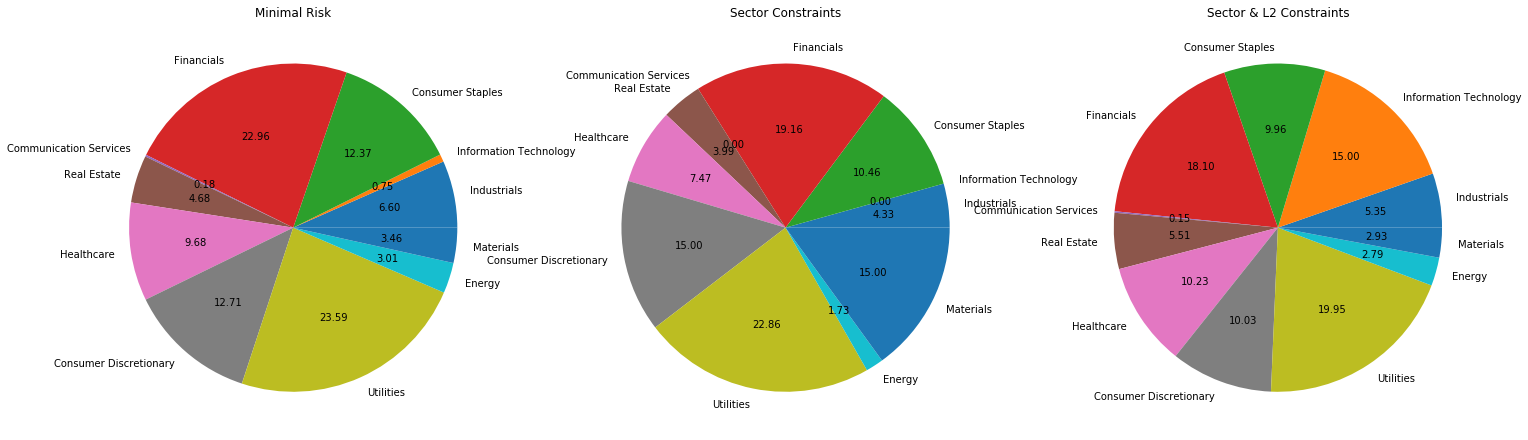

In [55]:
fig, axes = plt.subplots(1,3, figsize=(25,15))
for ax, idx in zip(axes, df3.index):
    ax.pie(df3.loc[idx], labels=df3.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();


# Comparing Weights and Results


### Overall Best Expected Annual Return

A Sharpe ratio below one signals suboptimal risk compared to return. This was likely because 68 out of 100 stocks in the best portfolios did not contain weights when left unconstrained, as seen above.

We can tell that uncorrelated and bullish sectoring outperforms all other methods on average by about 5%. This makes sense because using L2 raises the portfolio weights for non-performing stocks as well as performing ones. The fact that uncorrelated and bullish sector methods worked better than defensive ones implies that we are in a time of rapid economic growth and prosperity. This shows that the methods used should be carefully chosen based on current circumstances, to avoid having to run and separately evaluate numerous portfolios. 

In [41]:
print("\n Top performing portfolios sorted by highest sharpe ratios")


data.display_side_by_side(
[efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Sectors", "Sectors and L2"])

data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Defensive Sectors", "Defensive Sectors and L2"])

data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Bullish Sectors", "Bullish Sectors and L2"])


 Top performing portfolios sorted by highest sharpe ratios


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.093793,0.075409,0.978569
2,0.085096,0.071202,0.914245
34,0.085784,0.077133,0.852863
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
41,0.081946,0.076758,0.807022


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.085628,0.074657,0.879059
2,0.081281,0.069868,0.877098
39,0.088264,0.083560,0.816944
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
9,0.076125,0.076227,0.736292


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
38,0.096299,0.086483,0.882234
41,0.085804,0.075100,0.876222
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
41,0.073811,0.077979,0.690060


In [43]:
print("\n Top performing portfolios sorted by lowest volatility")

data.display_side_by_side(
[efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ["Minimal Risk", "Uncorrelated Sectors", "Sectors and L2"])

data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
def_efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ['Minimal Risk', 'Defensive Sectors', 'Defensive Sectors and L2'])

data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ["Minimal Risk", "Bullish Sectors", "Bullish Sectors and L2"])


 Top performing portfolios sorted by lowest volatility


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.085096,0.071202,0.914245
20,0.075212,0.072107,0.765694
1,0.072132,0.073416,0.710091
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
20,0.073677,0.073012,0.735180


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.081281,0.069868,0.877098
20,0.068317,0.071863,0.672359
1,0.068919,0.073340,0.667017
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
20,0.066480,0.073665,0.630969


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
20,0.066437,0.072609,0.639549
1,0.069839,0.074198,0.671701
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
20,0.062973,0.074764,0.574783


In [44]:
efficient_frontiers_sectors_results.iloc[38]
def_efficient_frontiers_sectors_results.iloc[38]
bull_efficient_frontiers_sectors_results.iloc[38]

Expected Return    0.091540
Volatility         0.086317
Sharpe Ratio       0.828802
Name: 38, dtype: float64

Expected Return    0.090468
Volatility         0.086338
Sharpe Ratio       0.816190
Name: 38, dtype: float64

Expected Return    0.096299
Volatility         0.086483
Sharpe Ratio       0.882234
Name: 38, dtype: float64

In [45]:
sample_port = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_weights[38]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sample_port[sector] = total_weight

res1 = pd.DataFrame.from_dict(data=sample_port,orient='index')
res1.rename(columns={0:"Uncorrelated Sectors"}, inplace=True)

sample_port = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in def_efficient_frontiers_sectors_weights[38]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sample_port[sector] = total_weight

res2 = pd.DataFrame.from_dict(data=sample_port,orient='index')
res2.rename(columns={0:"Defensive Sectors"}, inplace=True)

sample_port = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in bull_efficient_frontiers_sectors_weights[38]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sample_port[sector] = total_weight

res3 = pd.DataFrame.from_dict(data=sample_port,orient='index')
res3.rename(columns={0:"Bull-market Sectors"}, inplace=True)

combined = pd.concat([res1.T,res2.T,res3.T])

In [46]:
combined

,Financials,Energy,Utilities,Healthcare,Materials,Consumer Staples,Consumer Discretionary,Communication Services,Real Estate,Industrials,Information Technology
Uncorrelated Sectors,0.08480,0.00299,0.22420,0.05796,0.04741,0.07497,0.12801,0.0,0.07852,0.15112,0.14999
Defensive Sectors,0.11343,0.00585,0.22177,0.08063,0.06774,0.15000,0.14553,0.0,0.02000,0.17506,0.02000
Bull-market Sectors,0.15000,0.00335,0.21643,0.04396,0.15001,0.05729,0.15001,0.0,0.06771,0.14049,0.02076


Comparing the summed sector weights, we can see that all cases emphasise utilities and industrials (consistently above 10% and 15%), whilst energy and communication services are kept to a minimum (below 1%). As the bullish allocation did not contain any upper bounds on sectors which consistently performed well, the minimum bounds for sectors within the bullish allocation strategy seemed to garner greater return than risk (the same applies for uncorrelated sectoring). 


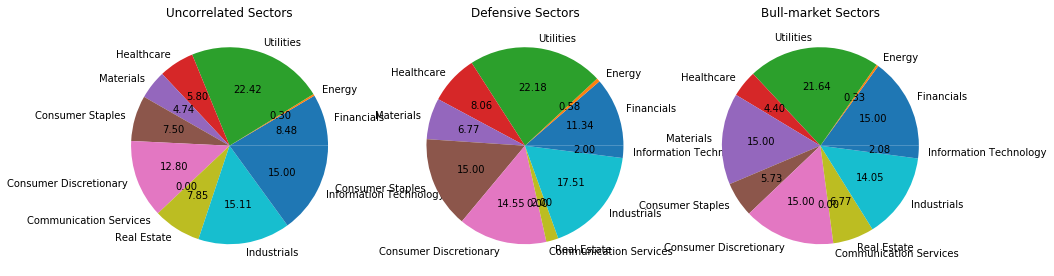

In [56]:
fig, axes = plt.subplots(1,3, figsize=(15,15))
for ax, idx in zip(axes, combined.index):
    ax.pie(combined.loc[idx], labels=combined.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();

In [48]:
combined.loc["Uncorrelated Sectors"]

Financials                0.08480
Energy                    0.00299
Utilities                 0.22420
Healthcare                0.05796
Materials                 0.04741
Consumer Staples          0.07497
Consumer Discretionary    0.12801
Communication Services    0.00000
Real Estate               0.07852
Industrials               0.15112
Information Technology    0.14999
Name: Uncorrelated Sectors, dtype: float64

In [50]:
index_best_efficient_frontier_return = efficient_frontiers_results["Expected Return"].argmax()
index_best_sector_return = efficient_frontiers_sectors_results["Expected Return"].argmax()
index_best_sector_L2_return = efficient_frontiers_sectors_L2_results["Expected Return"].argmax()

In addition, the number of zero weighted stocks dropped from 68 to 46 with sector constraints, and finally to only 20 with L2 regularisation:

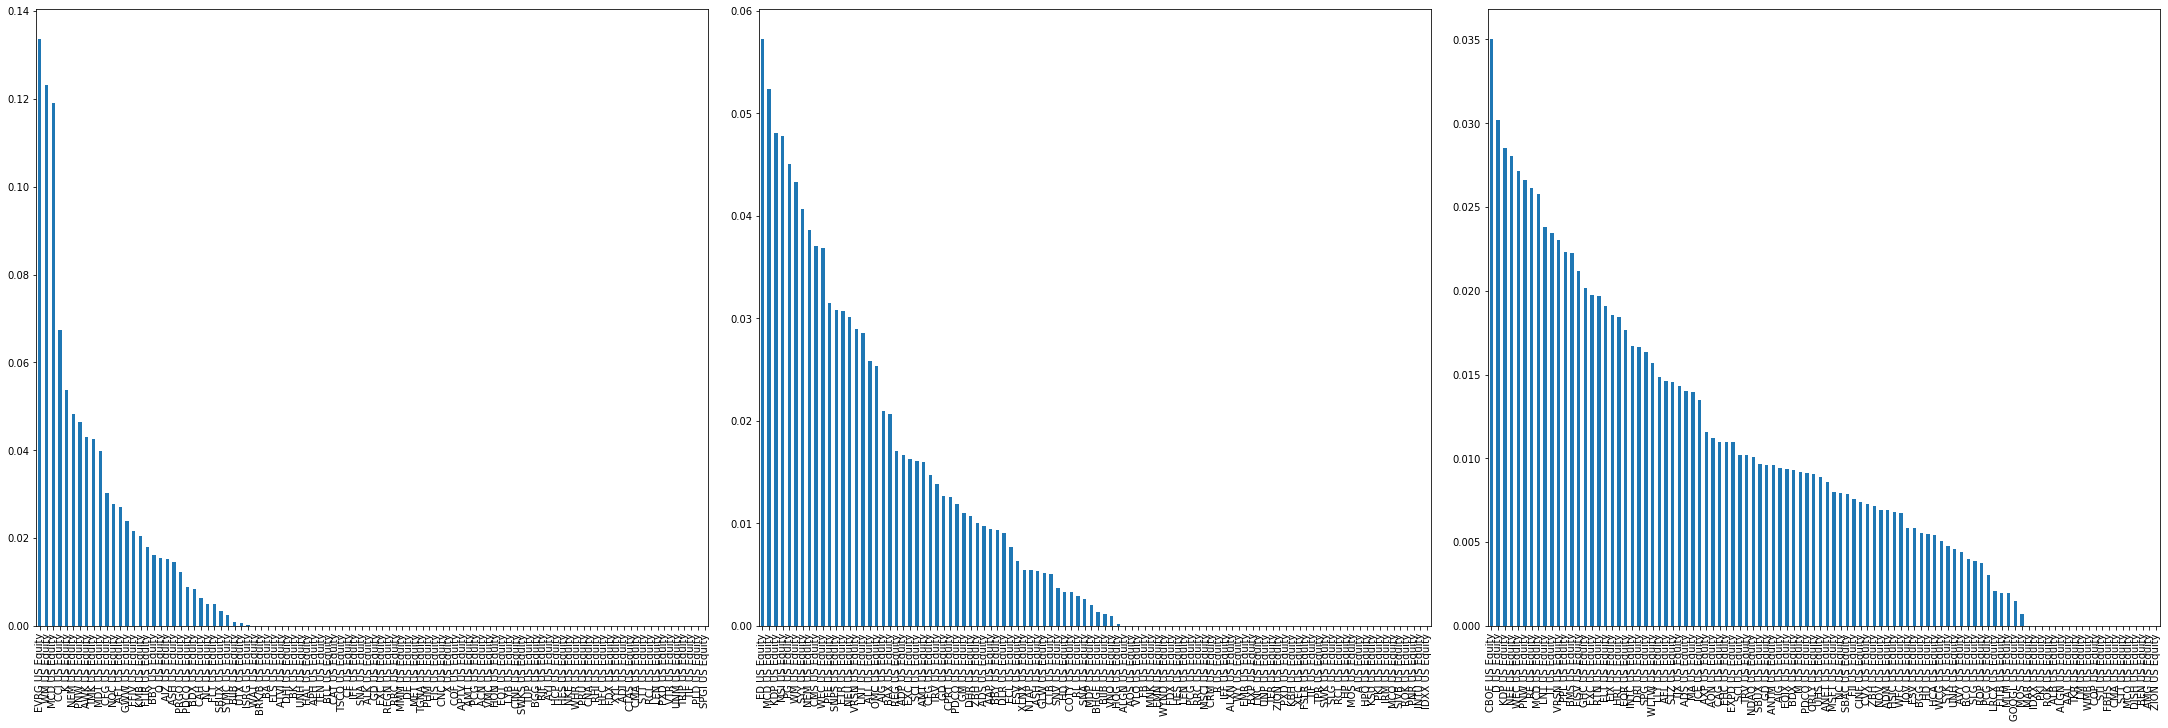

In [51]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), constrained_layout=True)

efficient_frontiers_weights[index_best_efficient_frontier_return]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[0]);
efficient_frontiers_sectors_weights[index_best_sector_return]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[1]);
efficient_frontiers_sectors_L2_weights[index_best_sector_L2_return]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[2]);

In [52]:
p = list(efficient_frontiers_weights[index_best_efficient_frontier_return]["Weights"]);

num_small = len([i for i in range(len(p)) if p[i] <= 1e-4])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

68/100 tickers have zero weight


In [53]:
q = list(efficient_frontiers_sectors_weights[index_best_sector_return]["Weights"]);

num_small = len([i for i in range(len(q)) if q[i] <= 1e-9])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

46/100 tickers have zero weight


In [54]:
r = list(efficient_frontiers_sectors_L2_weights[index_best_sector_L2_return]["Weights"]);

num_small = len([i for i in range(len(r)) if r[i] <= 1e-9])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

20/100 tickers have zero weight


From this fact, the L2 models were worse than other models, most likely due to increased weights in stocks which output a worse expected return.

# References:

[1] Harry Markowitz. Portfolio selection. The journal of finance, 7(1):77–91, 1952.

[2] Maier, Jon (2017). CIO Insights: Sector Investing and Correlations. Global X. https://www.globalxetfs.com/cio-insights-sector-investing-and-correlations/ 

